# Manually Selection of the Most Likely Causal Genes from Significant TWAS Genes

## Aim

Genomewide MR was skipped due to missing `MAF` column in the imputed GWAS sumstats, and our [TWAS pipeline](https://github.com/rl3328/xqtl-protocol/blob/main/code/pecotmr_integration/twas_ctwas.ipynb) runs TWAS and MR in the same step (`twas`). This notebook serves as a quick rescue to manually diminish noise from LD hitchhiking and identify the most likely causal genes.



## Steps

### 1. Filter genes qualified for MR analysis

Most thresholds follow the default requirements in \[`twas`], except I use a stricter `twas_pval` cutoff. The reason is that I want to directly apply the filter to “significant” TWAS genes in my manuscript while also saving resources.

**Criteria:**

1. Strong and reliable TWAS signals:

   * `twas_pval < 2.5*1e-6`
   * `rsq_cv > 0.01`
   * `rsq_pval < 0.05`
2. Strong GWAS signals:

   * Have `CS`, which can be extracted from `twas_weight(.rds)` files

### 2. Manually select the most likely causal gene

Within each LD block and by context, I define the gene with the strongest GWAS signal as follows:

* For each gene–context combination:

  * If no credible set (CS) is available, skip (this corresponds to filtering step 1.2).
  * If a 95% CS exists, select the gene containing the variant with the highest PIP within the 95% CS. If not, fall back to 70% CS.
  * If a 70% CS exists, select the gene containing the variant with the highest PIP within the 70% CS. If not, fall back to 50% CS.
  * If a 50% CS exists, select the gene containing the variant with the highest PIP within the 50% CS.



## Note

There are some differences between this identification and the [loose gene list](https://github.com/rl3328/xqtl-analysis/blob/main/production/image_QTL/interested_genes/TWAS_QTL/loose_gene/image_Aging2_gene_list.tsv).

* Loose list: 42 genes, filtered by `is_selected_method` and `twas_pval < 2.5*1e-6`
* Current identification: 443 genes are strong TWAS genes(twas_pval < 2.5*1e-6 & rsq_cv > 0.01 & pval_cv < 0.05) for Aging2 and Knight cohort, 48 genes were identified as the final list.



## Input

1. **Merged TWAS results** (`*.twas.tsv.gz`):

   * `s3://statfungen/ftp_fgc_xqtl/interactive_analysis/rl3328/image_QTL/twas/image_Aging2_twas_merged.tsv.gz.combined_twas.tsv.gz`
2. **xQTL\_meta\_file** (meta file specifying TWAS weight paths by cohort):

   * `s3://statfungen/ftp_fgc_xqtl/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv`


## Plan

Other GWAS studies and other cohorts will be analyzed in the same way.


In [1]:
library(data.table)
library(tidyverse)
library(pecotmr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second()
✖ purrr::transpose()   masks data.table::transpose()
✖ lubridate::wday() 

In [2]:
setwd("~/data")

In [3]:
##Bonfferroni correction is too strict
# Aging2_twas = fread("~/project/image_QTL/twas/multiple_testing/image_Aging2_twas_bonff.bonf_corrected.tsv.gz")


In [4]:
Aging2_twas = fread("~/project/image_QTL/twas/image_Aging2_twas_merged.tsv.gz.combined_twas.tsv.gz")


In [8]:
# weight_db_list = fread("~/data/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/project/image_QTL/twas/MSBB_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/data/interactive_analysis/cl4215/ROSMAP_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/data/interactive_analysis/cl4215/ROSMAP_mega_twas_wgw_xqtl_meta_data.tsv")


In [9]:
# No gene presents in multiple blocks
genes_in_multiple_blocks <- Aging2_twas %>% group_by(molecular_id) %>% summarise(
    number_of_blocks = n_distinct(block)) %>%
    filter(number_of_blocks > 1)

print(genes_in_multiple_blocks)

# A tibble: 0 × 2
# ℹ 2 variables: molecular_id <chr>, number_of_blocks <int>


In [10]:
head(Aging2_twas)
dim(Aging2_twas)

chr,molecular_id,TSS,start,end,context,gwas_study,method,is_imputable,is_selected_method,rsq_cv,pval_cv,twas_z,twas_pval,type,block,region,study_context,source_file
<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging2,enet,TRUE,FALSE,0.098757440,8.923911e-10,0.4422873,0.65828134,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging2,lasso,TRUE,FALSE,0.103370596,3.541036e-10,0.5153586,0.60630249,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging2,mrash,TRUE,FALSE,0.089177838,6.013310e-09,0.3763701,0.70664179,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging2,susie,TRUE,TRUE,0.121638427,8.766557e-12,0.4166957,0.67690100,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000059915,102421538,101402617,103680000,Knight_eQTL_brain,image_Aging2,enet,TRUE,FALSE,0.007872702,5.201216e-02,2.3533373,0.01860575,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000059915,102421538,101402617,103680000,Knight_eQTL_brain,image_Aging2,lasso,TRUE,FALSE,0.006195072,7.447581e-02,2.2734046,0.02300181,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz


[1] 920648     19

In [8]:
# Strong and reliable TWAS signals:
Aging2_twas_filtered <- Aging2_twas |>
    filter(
        twas_pval < 2.5*1e-6 &     # Stricter p-value threshold 
        rsq_cv > 0.01 &          # Cross-validation R²
        pval_cv < 0.05          # R² significance
    )
Aging2_block = unique(Aging2_twas_filtered$block)

In [9]:
dim(Aging2_twas_filtered)

[1] 1077   19

In [11]:
most_likely_causal_genes = Aging2_twas_filtered |> 
  group_by(context, region) |> 
  slice_max(twas_z, n = 1)

In [12]:
head(most_likely_causal_genes)
dim(most_likely_causal_genes)

chr,molecular_id,TSS,start,end,context,gwas_study,method,is_imputable,is_selected_method,rsq_cv,pval_cv,twas_z,twas_pval,type,block,region,study_context,source_file
<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
10,ENSG00000203791,124791886,123748149,125840000,AC_DeJager_eQTL,image_Aging2,mvsusie,TRUE,TRUE,0.48075408,2.236695e-86,-6.821231,9.026387e-12,eQTL,chr10_123788803_125506866,chr10_123788803_125506866,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr10_123788803_125506866.twas.tsv.gz
10,ENSG00000095787,28532492,26880000,30640000,AC_DeJager_eQTL,image_Aging2,enet,TRUE,FALSE,0.08953137,5.957857e-14,-4.844148,1.271560e-06,eQTL,chr10_28362609_29522130,chr10_28362609_29522130,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr10_28362609_29522130.twas.tsv.gz
12,ENSG00000088992,117099478,115920000,118120000,AC_DeJager_eQTL,image_Aging2,bayes_l,TRUE,FALSE,0.20059666,8.144650e-31,8.770712,1.775404e-18,eQTL,chr12_115165608_117668628,chr12_115165608_117668628,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr12_115165608_117668628.twas.tsv.gz
12,ENSG00000111490,64759483,63560000,66160000,AC_DeJager_eQTL,image_Aging2,bayes_l,TRUE,FALSE,0.03614365,1.858085e-06,5.040455,4.644258e-07,eQTL,chr12_61991992_65677087,chr12_61991992_65677087,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr12_61991992_65677087.twas.tsv.gz
16,ENSG00000169203,29505998,25040000,34000000,AC_DeJager_eQTL,image_Aging2,mrash,TRUE,FALSE,0.14495571,4.118059e-22,5.358868,8.374506e-08,eQTL,chr16_26796952_29685831,chr16_26796952_29685831,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr16_26796952_29685831.twas.tsv.gz
16,ENSG00000149930,29973867,28360000,34000000,AC_DeJager_eQTL,image_Aging2,mrash,TRUE,FALSE,0.01527578,1.492151e-03,6.794680,1.085532e-11,eQTL,chr16_29685831_46381513,chr16_29685831_46381513,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr16_29685831_46381513.twas.tsv.gz


[1] 190  19

In [14]:
most_likely_causal_genes |> count(molecular_id) |> nrow()

[1] 190

In [16]:
Aging2_gene = unique(most_likely_causal_genes$molecular_id)

In [17]:
image_Aging2_gene_list <- Aging2_twas |> 
  dplyr::filter(molecular_id %in% Aging2_gene) |> 
  dplyr::mutate(`#chr` = paste0("chr", chr), molecular_id = molecular_id) |> 
  dplyr::select(`#chr`, start, end, molecular_id) |> 
  unique()

In [18]:
dim(image_Aging2_gene_list)

[1] 74  4

In [19]:
DNE_QTL_gene = fread("~/project/image_QTL/twas/annotated_dne_gene.tsv")


In [20]:
image_Aging2_QTL_gene = DNE_QTL_gene |> filter(str_detect(event_ID, "image_Aging2")) |> dplyr::select(-strand,-event_ID)
                                        

In [21]:
image_Aging2_gene = bind_rows(image_Aging2_gene_list, image_Aging2_QTL_gene)

In [22]:
fwrite(image_Aging2_gene, "~/DNE_xQTL_paper/main_text/4_candidate_genes/staging/interested_genes/TWAS_QTL/manual_cTWAS_QTL_gene/image_Aging2_gene_list.tsv", sep = '\t')

### image_Aging2_QTL list

In [23]:

library(clusterProfiler)
library(org.Hs.eg.db)




clusterProfiler v4.10.1  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:stats’:

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are

In [24]:
image_Aging2_gene = fread("~/DNE_xQTL_paper/main_text/4_candidate_genes/staging/interested_genes/TWAS_QTL/manual_cTWAS_QTL_gene/image_Aging2_gene_list.tsv")

In [25]:
Aging2_sig_gene_ego <- enrichGO(
  gene          = unique(image_Aging2_gene$molecular_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [26]:
head(Aging2_sig_gene_ego, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0090085,GO:0090085,regulation of protein deubiquitination,2/67,11/21261,0.0005282824,0.3028919,0.266984,ENSG00000136560/ENSG00000145901,2
GO:0030111,GO:0030111,regulation of Wnt signaling pathway,6/67,353/21261,0.0008545713,0.3028919,0.266984,ENSG00000019995/ENSG00000110492/ENSG00000109320/ENSG00000205269/ENSG00000146374/ENSG00000171056,6
GO:0035234,GO:0035234,ectopic germ cell programmed cell death,2/67,18/21261,0.0014487997,0.3028919,0.266984,ENSG00000143194/ENSG00000171552,2
GO:0060828,GO:0060828,regulation of canonical Wnt signaling pathway,5/67,270/21261,0.0016179157,0.3028919,0.266984,ENSG00000110492/ENSG00000109320/ENSG00000205269/ENSG00000146374/ENSG00000171056,5
GO:0071260,GO:0071260,cellular response to mechanical stimulus,3/67,74/21261,0.0016525605,0.3028919,0.266984,ENSG00000102882/ENSG00000006062/ENSG00000109320,3
GO:0010759,GO:0010759,positive regulation of macrophage chemotaxis,2/67,20/21261,0.0017918625,0.3028919,0.266984,ENSG00000110492/ENSG00000102882,2
GO:1902307,GO:1902307,positive regulation of sodium ion transmembrane transport,2/67,21/21261,0.0019764588,0.3028919,0.266984,ENSG00000088992/ENSG00000089250,2
GO:0000723,GO:0000723,telomere maintenance,4/67,185/21261,0.0027750960,0.3028919,0.266984,ENSG00000102882/ENSG00000169592/ENSG00000108384/ENSG00000258724,4
GO:0010623,GO:0010623,programmed cell death involved in cell development,2/67,25/21261,0.0028006655,0.3028919,0.266984,ENSG00000143194/ENSG00000171552,2


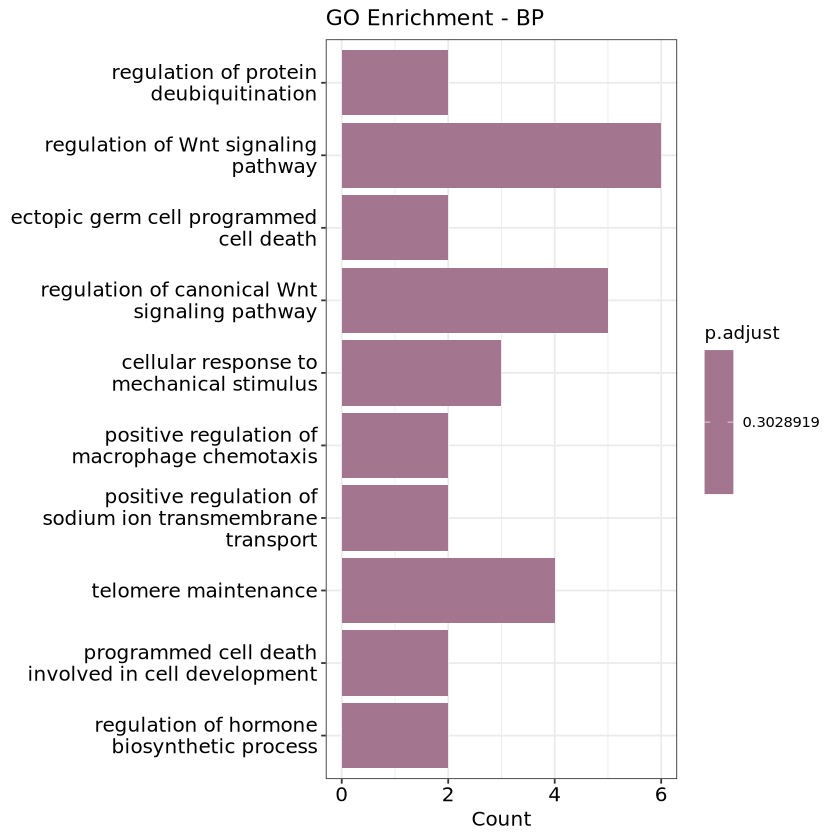

In [27]:
barplot(Aging2_sig_gene_ego, showCategory = 10, title = "GO Enrichment - BP")

In [28]:
Aging2_sig_gene_ego_cc <- enrichGO(
  gene          = unique(image_Aging2_gene$molecular_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "CC",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [29]:
head(Aging2_sig_gene_ego_cc, n=15)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0016363,GO:0016363,nuclear matrix,3/72,134/22568,0.009058578,0.2885364,0.2583614,ENSG00000184575/ENSG00000159267/ENSG00000203760,3
GO:0034399,GO:0034399,nuclear periphery,3/72,159/22568,0.014354955,0.2885364,0.2583614,ENSG00000184575/ENSG00000159267/ENSG00000203760,3
GO:0036064,GO:0036064,ciliary basal body,3/72,181/22568,0.020201207,0.2885364,0.2583614,ENSG00000111490/ENSG00000174989/ENSG00000076382,3
GO:0000776,GO:0000776,kinetochore,3/72,184/22568,0.021085807,0.2885364,0.2583614,ENSG00000076382/ENSG00000203760/ENSG00000258724,3
GO:0000779,GO:0000779,"condensed chromosome, centromeric region",3/72,195/22568,0.024509551,0.2885364,0.2583614,ENSG00000076382/ENSG00000203760/ENSG00000258724,3
GO:0097136,GO:0097136,Bcl-2 family protein complex,1/72,10/22568,0.031455611,0.2885364,0.2583614,ENSG00000171552,1
GO:0002116,GO:0002116,semaphorin receptor complex,1/72,11/22568,0.034546984,0.2885364,0.2583614,ENSG00000221866,1
GO:0072534,GO:0072534,perineuronal net,1/72,11/22568,0.034546984,0.2885364,0.2583614,ENSG00000038427,1
GO:0098850,GO:0098850,extrinsic component of synaptic vesicle membrane,1/72,11/22568,0.034546984,0.2885364,0.2583614,ENSG00000149927,1


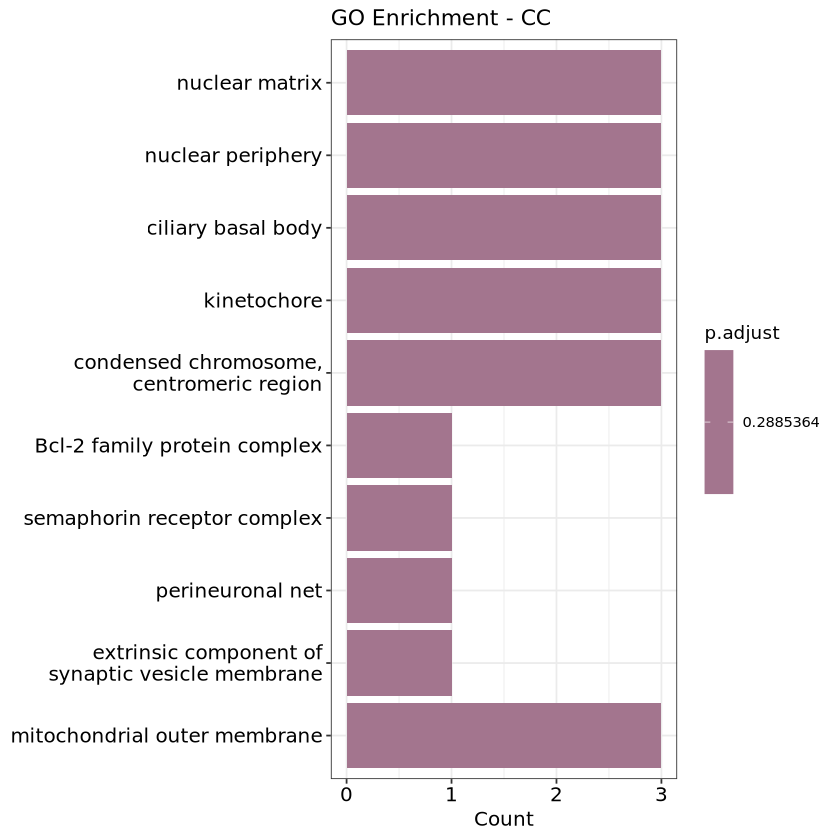

In [30]:
barplot(Aging2_sig_gene_ego_cc, showCategory = 10, title = "GO Enrichment - CC")

In [31]:
image_Aging2_sig_gene_ego_mf <- enrichGO(
  gene          = unique(image_Aging2_gene$molecular_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "MF",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [32]:
head(image_Aging2_sig_gene_ego_mf, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0000400,GO:0000400,four-way junction DNA binding,2/69,18/21059,0.001564821,0.1688191,0.1330790,ENSG00000108384/ENSG00000116062,2
GO:0140664,GO:0140664,ATP-dependent DNA damage sensor activity,2/69,24/21059,0.002787230,0.1688191,0.1330790,ENSG00000108384/ENSG00000116062,2
GO:0051537,GO:0051537,"2 iron, 2 sulfur cluster binding",2/69,26/21059,0.003268227,0.1688191,0.1330790,ENSG00000183336/ENSG00000145354,2
GO:0004709,GO:0004709,MAP kinase kinase kinase activity,2/69,27/21059,0.003522240,0.1688191,0.1330790,ENSG00000149930/ENSG00000006062,2
GO:0140612,GO:0140612,DNA damage sensor activity,2/69,28/21059,0.003785182,0.1688191,0.1330790,ENSG00000108384/ENSG00000116062,2
GO:0004722,GO:0004722,protein serine/threonine phosphatase activity,3/69,108/21059,0.005376530,0.1757198,0.1385188,ENSG00000108389/ENSG00000141298/ENSG00000175175,3
GO:0008170,GO:0008170,N-methyltransferase activity,3/69,109/21059,0.005515869,0.1757198,0.1385188,ENSG00000203791/ENSG00000066651/ENSG00000145002,3
GO:0000217,GO:0000217,DNA secondary structure binding,2/69,41/21059,0.007989311,0.1834273,0.1445945,ENSG00000108384/ENSG00000116062,2
GO:0008094,GO:0008094,"ATP-dependent activity, acting on DNA",3/69,127/21059,0.008400973,0.1834273,0.1445945,ENSG00000127311/ENSG00000108384/ENSG00000116062,3


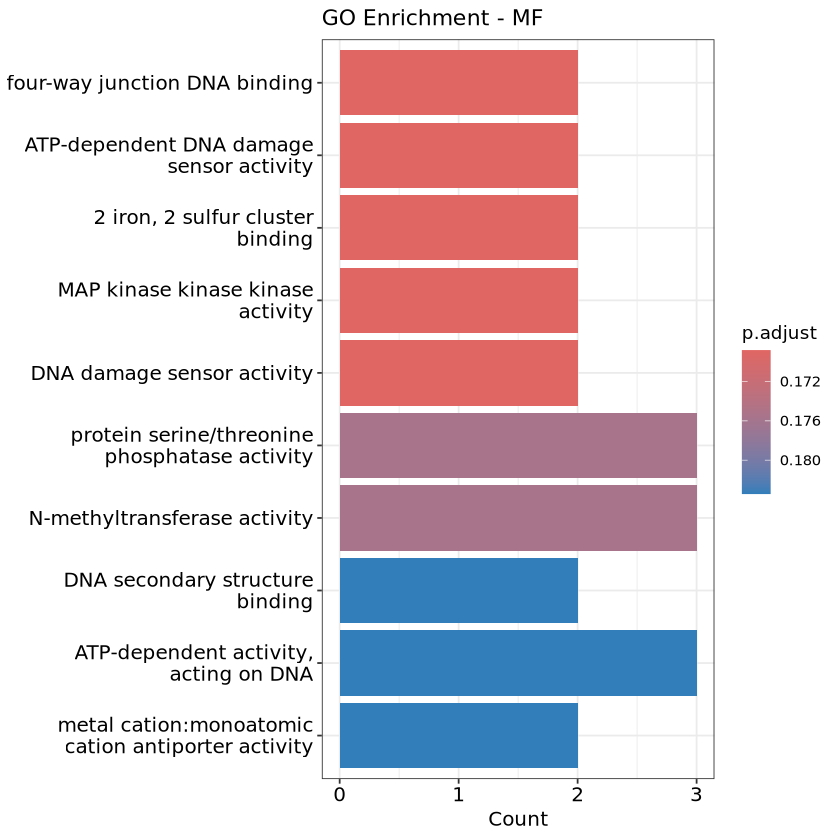

In [33]:
barplot(image_Aging2_sig_gene_ego_mf, showCategory = 10, title = "GO Enrichment - MF")

In [34]:
entrez_ids <- bitr(image_Aging2_gene$molecular_id, fromType = "ENSEMBL", 
                   toType = "ENTREZID", OrgDb = org.Hs.eg.db)

kegg_enrich <- enrichKEGG(gene         = entrez_ids$ENTREZID,
                          organism     = 'hsa',
                          pvalueCutoff = 1,
                         qvalueCutoff = 1)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(image_Aging2_gene$molecular_id, fromType = "ENSEMBL", toType = "ENTREZID", :
“1.33% of input gene IDs are fail to map...”
Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...



In [35]:
kegg_enrich %>% head(n=25)

,category,subcategory,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
hsa04064,Environmental Information Processing,Signal transduction,hsa04064,NF-kappa B signaling pathway,4/31,105/9446,0.0003600489,0.03277042,0.02228621,9020/598/5335/4790,4
hsa05417,Human Diseases,Cardiovascular disease,hsa05417,Lipid and atherosclerosis,5/31,216/9446,0.0006243663,0.03277042,0.02228621,5595/598/5335/10010/4790,5
hsa04660,Organismal Systems,Immune system,hsa04660,T cell receptor signaling pathway,4/31,122/9446,0.0006363366,0.03277042,0.02228621,5595/9020/5335/4790,4
hsa05166,Human Diseases,Infectious disease: viral,hsa05166,Human T-cell leukemia virus 1 infection,5/31,224/9446,0.0007364140,0.03277042,0.02228621,5595/1031/9020/598/4790,5
hsa04210,Cellular Processes,Cell growth and death,hsa04210,Apoptosis,4/31,137/9446,0.0009831376,0.03287861,0.02235979,5595/9020/598/4790,4
hsa05131,Human Diseases,Infectious disease: bacterial,hsa05131,Shigellosis,5/31,253/9446,0.0012725280,0.03287861,0.02235979,5595/598/5335/4790/10318,5
hsa05120,Human Diseases,Infectious disease: bacterial,hsa05120,Epithelial cell signaling in Helicobacter pylori infection,3/31,71/9446,0.0015729963,0.03287861,0.02235979,9020/5335/4790,3
hsa01524,Human Diseases,Drug resistance: antineoplastic,hsa01524,Platinum drug resistance,3/31,75/9446,0.0018419967,0.03287861,0.02235979,5595/2956/598,3
hsa05212,Human Diseases,Cancer: specific types,hsa05212,Pancreatic cancer,3/31,77/9446,0.0019866181,0.03287861,0.02235979,5595/598/4790,3


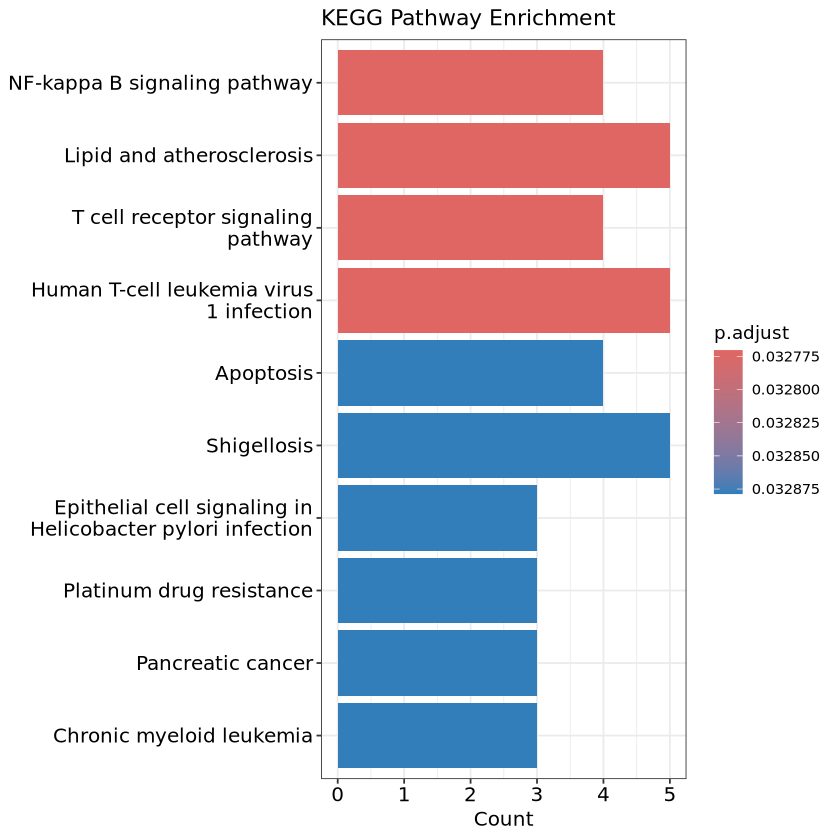

In [36]:
barplot(kegg_enrich, showCategory = 10, title = "KEGG Pathway Enrichment")